Comparing Rainfall : Seattle, WA V.S Vancouver, BC

#Import libraries



In [496]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [402]:
#load data 
seattle_df = pd.read_csv("../data/seattle_rain.csv")
vancouver_df = pd.read_csv("../data/vancouver_rain.csv")


In [ ]:
# Inspect Data
display(vancouver_df.head(5))
display(vancouver_df.info())

,STATION,NAME,DATE,DAPR,MDPR,PRCP,SNOW,SNWD
0,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-01,NaN,NaN,0.00,0.0,NaN
1,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-02,NaN,NaN,0.00,0.0,NaN
2,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-03,NaN,NaN,0.00,0.0,NaN
3,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-04,NaN,NaN,0.00,0.0,NaN
4,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-05,NaN,NaN,0.06,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  1531 non-null   object 
 1   NAME     1531 non-null   object 
 2   DATE     1531 non-null   object 
 3   DAPR     30 non-null     float64
 4   MDPR     30 non-null     float64
 5   PRCP     1501 non-null   float64
 6   SNOW     701 non-null    float64
 7   SNWD     26 non-null     float64
dtypes: float64(5), object(3)
memory usage: 95.8+ KB


None

In [ ]:
#Rename Column for clarity
seattle_df.rename(columns={'PRCP':'seattle_precipitation', 'DATE' : 'date'}, inplace= True)
vancouver_df.rename(columns={'PRCP':'vancouver_precipitation','DATE': 'date'}, inplace= True)


,date,vancouver_precipitation
0,2018-01-01,0.0
1,2018-01-02,0.0
2,2018-01-03,0.0


In [497]:
#Convert data columns to datetime type
seattle_df['date'] = pd.to_datetime(seattle_df['date'])
vancouver_df['date'] = pd.to_datetime(vancouver_df['date'])


In [498]:
# Remove duplicate rows if any
seattle_df = seattle_df.drop_duplicates()
vancouver_df = vancouver_df.drop_duplicates()

# Filter datasets to only include dates between 2018-01-01 and 2022-12-31
start_date = '2018-01-01'
end_date = '2022-12-31'

seattle_df = seattle_df[(seattle_df['date'] >= start_date) & (seattle_df['date'] <= end_date)]
vancouver_df = vancouver_df[(vancouver_df['date'] >= start_date) & (vancouver_df['date'] <= end_date)]


In [499]:
#Select only date and precipitation columns
seattle_df = seattle_df[['date', 'seattle_precipitation']]
vancouver_df = vancouver_df[['date', 'vancouver_precipitation']]

In [ ]:
#Merge dataset
combine_city = pd.merge(seattle_df, vancouver_df, on = 'date')

#rename column 
combine_city.rename(columns={'precipition_x':'seattle_precipitation','precipition_y':'vancouver_precipitation'})




,date,seattle_precipitation,vancouver_precipitation
0,2018-01-01,0.00,0.00
1,2018-01-02,0.00,0.00
2,2018-01-03,0.00,0.00
3,2018-01-04,0.00,0.00
4,2018-01-05,0.25,0.06


In [ ]:
# Ensure that the data frame is in a tidy, or long, format.
tidy_df = combine_city.melt(id_vars='date', 
                            value_vars=['seattle_precipitation', 'vancouver_precipitation'],
                            var_name='city', 
                            value_name='precipitation')

# Clean up city names
tidy_df['city'] = tidy_df['city'].replace({
    'seattle_precipitation': 'Seattle',
    'vancouver_precipitation': 'Vancouver'
})

# Create a month column
tidy_df['month'] = tidy_df['date'].dt.to_period('M')
tidy_df['year'] = tidy_df['date'].dt.year



In [502]:
#Handling missing months
# Group by city and month to get total monthly rainfall
monthly_rainfall = tidy_df.groupby(['city', 'month'])['precipitation'].sum().reset_index()

# Create all combinations of city and month
all_months = pd.period_range(start=monthly_rainfall['month'].min(), end=monthly_rainfall['month'].max(), freq='M')
cities = monthly_rainfall['city'].unique()
all_combinations = pd.MultiIndex.from_product([cities, all_months], names=['city', 'month'])

# Reindex to include missing months
monthly_rainfall = monthly_rainfall.set_index(['city','month']).reindex(all_combinations).reset_index()

# Fill missing precipitation values with the mean of each city
monthly_rainfall['precipitation'] = monthly_rainfall.groupby('city')['precipitation'].transform(
    lambda x: x.fillna(x.mean())
)

# rename column for clarity
monthly_rainfall.rename(columns={'precipitation': 'monthly_total'}, inplace=True)

monthly_rainfall.head()

,city,month,monthly_total
0,Seattle,2018-01,1.460000
1,Seattle,2018-02,2.919273
2,Seattle,2018-03,1.460000
3,Seattle,2018-04,5.390000
4,Seattle,2018-05,0.010000


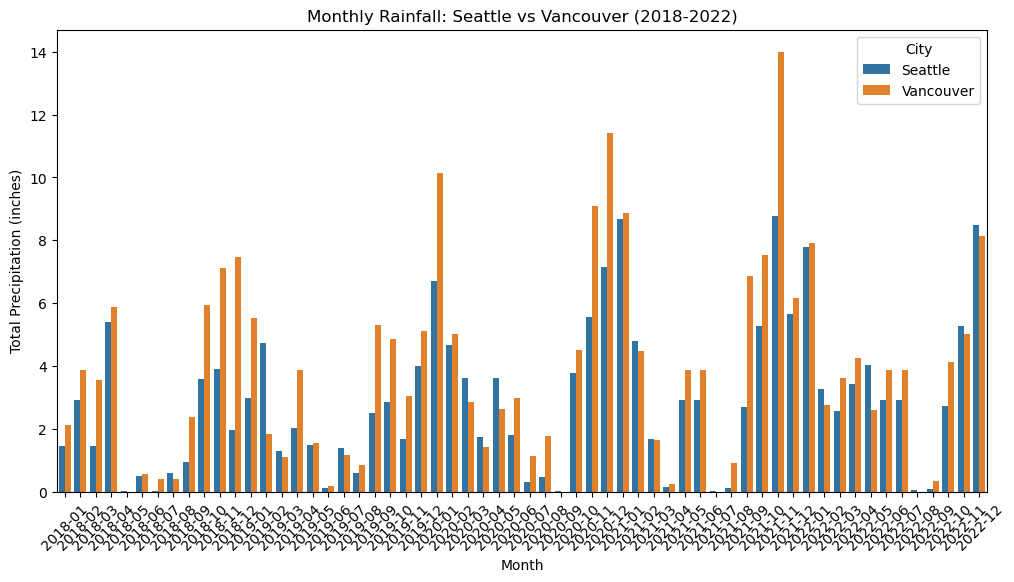

In [503]:
#plot monthly rainfall
plt.figure(figsize=(12,6))
sns.barplot(data=monthly_rainfall, x='month', y='monthly_total', hue='city')
plt.xticks(rotation=45)
plt.title('Monthly Rainfall: Seattle vs Vancouver (2018-2022)')
plt.xlabel('Month')
plt.ylabel('Total Precipitation (inches)')
plt.legend(title='City')
plt.show()


* Vancouver generally has more rainy days than Seattle, especially in the late fall and winter (October–March).

* Seattle’s highest rainy month is October 2021, while Vancouver peaks in October 2021.

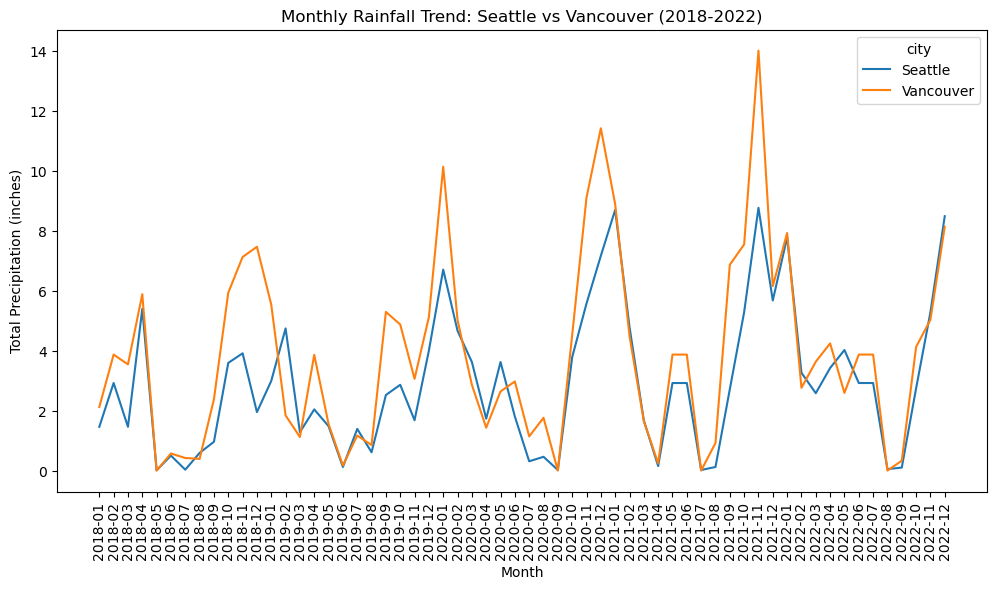

In [504]:
#Using lineplot to show trends
monthly_rainfall['month_str'] = monthly_rainfall['month'].astype(str)
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_rainfall, x='month_str', y='monthly_total', hue='city')
plt.xticks(rotation=90)
plt.title('Monthly Rainfall Trend: Seattle vs Vancouver (2018-2022)')
plt.xlabel('Month')
plt.ylabel('Total Precipitation (inches)')
plt.show()

* October 2021 showed the biggest gap, with Vancouver much wetter than Seattle.

* Both cities have peaks in late fall/winter (Oct–Feb) and lows in summer (Jun–Aug).

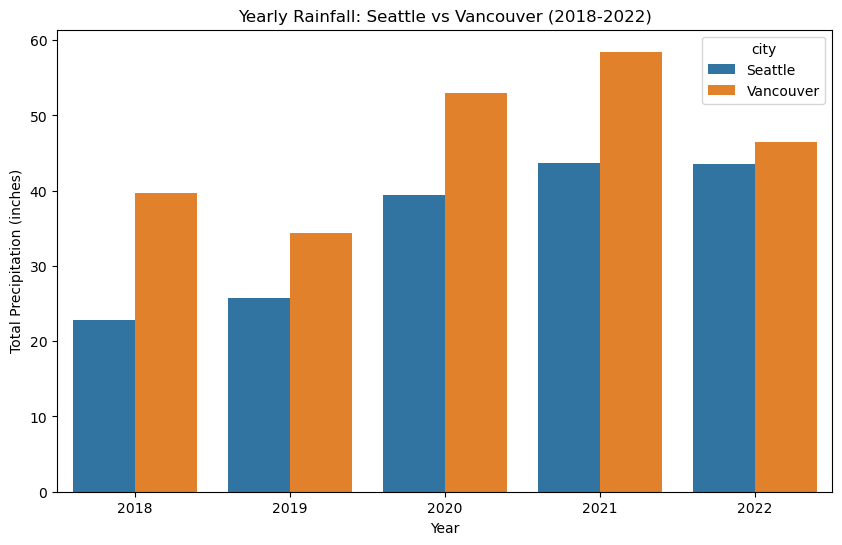

In [505]:
#compare yearly rainfall

monthly_rainfall['year'] = monthly_rainfall['month'].dt.year
yearly_rain = monthly_rainfall.groupby(['city','year'])['monthly_total'].sum().reset_index()
yearly_rain.rename(columns={'monthly_total': 'yearly_precipitation'}, inplace=True)

# Plot yearly rainfall
plt.figure(figsize=(10,6))
sns.barplot(data=yearly_rain, x='year', y='yearly_precipitation', hue='city')
plt.title('Yearly Rainfall: Seattle vs Vancouver (2018-2022)')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (inches)')
plt.show()

* Over 5 years Vancouver has the highest rain and Vancouver typically adds 10-15 inches more rain than seattle each year.
* Both cities saw a sharp increase from 2019 to 2020.